In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [43]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

# Discrete protein number selectivity

In [52]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)

In [53]:
parms = GenParms(10.0**np.arange(0,7.01,0.25), 2, 2, 10)

In [55]:
def pFree_Monomer(parm, V):
    # Assume there is only one protein
    KPS = parm['KPS']
    KPP = parm['KPP']
    KPN = parm['KPN']
    S = parm['CS0'] * V
    N = parm['CN0'] * V
    C0 = 0.6022
    gamma = parm['gamma']
    return 1 / (1 + KPS/V*S + KPN/V*N + gamma*KPS/V*KPN/V*S*N)

def pFree_Dimer(parm, V, cluster:bool):
    # Assume there are two proteins
    KPS = parm['KPS']
    KPP = parm['KPP']
    KPN = parm['KPN']
    S = parm['CS0'] * V
    N = parm['CN0'] * V
    C0 = 0.6022
    gamma = parm['gamma']
    
    # relative probabilities
    # containing free monomers
    P_P = 1
    PS_P = 2*KPS/V*S
    PN_P = 2*KPN/V*N
    PSN_P = 2*gamma*(KPS/V)*(KPN/V) * S*N
    # monomer + monomer
    PS_PS = (KPS/V)**2 * S*(S-1)
    PN_PN = (KPN/V)**2 * N*(N-1)
    PS_PN = 2*(KPS/V)*(KPN/V) * S*N
    PSN_PS = 2*gamma*(KPS/V)**2*(KPN/V) * S*(S-1)*N
    PSN_PN = 2*gamma*(KPS/V)*(KPN/V)**2 * S*N*(N-1)
    PSN_PSN = (gamma*KPS/V*KPN/V)**2 * S*(S-1)*N*(N-1)
    # dimer, take Ptot = 2
    PP = 2*(KPP/V)*2
    PPS = 2*(KPP/V)*2*(KPS/V) * 2*S
    PPN = 2*(KPP/V)*2*(KPN/V) * 2*N
    PPSN = 2*gamma*(KPP/V)*2*KPS/V*KPN/V * 2*S*N
    PSPN = 2*gamma*(KPP/V)*2*KPS/V*KPN/V * 2*S*N
    PNPN = 2*gamma*(KPP/V)*(KPN/V)**2 * 2*N*(N-1)
    PSPS = 2*(KPP/V)*(KPS/V)*(KPS*C0) * 2*S
    PSPSN = 2*gamma*(KPP/V)*(KPS/V)*(KPS*C0)*2*(KPN/V) * 2*S*N
    PNPSN = 2*gamma**2*(KPP/V)*(KPN/V)**2*2*(KPS/V) * 2*N*(N-1)*S
    PSNPSN = 2*gamma**2*(KPP/V)*(KPN/V)**2*(KPS/V)*(KPS*C0) * 2*N*(N-1)*S
    
    if cluster:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PSPS + PSPSN + PNPSN + PSNPSN)
    else:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PNPSN)
    
    return (2*P_P + PS_P + PN_P + PSN_P) / total

def partition_Dimer(parm, V, cluster:bool):
    # Assume there are two proteins
    KPS = parm['KPS']
    KPP = parm['KPP']
    KPN = parm['KPN']
    S = parm['CS0'] * V
    N = parm['CN0'] * V
    C0 = 0.6022
    gamma = parm['gamma']
    
    # relative probabilities
    # containing free monomers
    P_P = 1
    PS_P = 2*KPS/V*S
    PN_P = 2*KPN/V*N
    PSN_P = 2*gamma*(KPS/V)*(KPN/V) * S*N
    # monomer + monomer
    PS_PS = (KPS/V)**2 * S*(S-1)
    PN_PN = (KPN/V)**2 * N*(N-1)
    PS_PN = 2*(KPS/V)*(KPN/V) * S*N
    PSN_PS = 2*gamma*(KPS/V)**2*(KPN/V) * S*(S-1)*N
    PSN_PN = 2*gamma*(KPS/V)*(KPN/V)**2 * S*N*(N-1)
    PSN_PSN = (gamma*KPS/V*KPN/V)**2 * S*(S-1)*N*(N-1)
    # dimer, take Ptot = 2
    PP = 2*(KPP/V)*2
    PPS = 2*(KPP/V)*2*(KPS/V) * 2*S
    PPN = 2*(KPP/V)*2*(KPN/V) * 2*N
    PPSN = 2*gamma*(KPP/V)*2*(KPS/V)*(KPN/V) * 2*S*N
    PSPN = 2*gamma*(KPP/V)*2*KPS/V*KPN/V * 2*S*N
    PNPN = 2*gamma*(KPP/V)*(KPN/V)**2 * 2*N*(N-1)
    PSPS = 2*(KPP/V)*2*(KPS/V)*(KPS*C0) * 2*S
    PSPSN = 2*gamma*(KPP/V)*2*(KPS/V)*(KPS*C0)*2*(KPN/V) * 2*S*N
    PNPSN = 2*gamma**2*(KPP/V)*2*(KPN/V)**2*2*(KPS/V) * 2*N*(N-1)*S
    PSNPSN = 2*gamma**2*(KPP/V)*2*(KPN/V)**2*(KPS/V)*(KPS*C0) * 2*N*(N-1)*S
    
    if cluster:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PSPS + PSPSN + PNPSN + PSNPSN)
    else:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PNPSN)
        
    return total
    
def differenceOfPfree(parm):
    # between clustered targets and separated targets
    # only for 2 proteins in the whole system
    V = 2 / parms['CS0'].unique()
    # partition functions
    Z_cluster = partition_Dimer(parm, V, True)
    Z_separate = partition_Dimer(parm, V, False)
    Z_tot = Z_cluster + Z_separate
    # when two proteins are in the same env
    pfree_cluster_2protein = pFree_Dimer(parm, V, True)*2
    pfree_separate_2protein = pFree_Dimer(parm, V, False)*2
    # expected free protein
    pfree_cluster = Z_cluster / Z_tot * pfree_cluster_2protein
    pfree_separate = Z_separate / Z_tot * pfree_separate_2protein
    return pfree_cluster, pfree_separate

In [56]:
def estimateSelectivity(parm):
    # only for 2 proteins in the whole system
    V = 2 / parms['CS0'].unique()
    # partition function for cluster
    Z_cluster = partition_Dimer(parm, V, True)
    # partition function for separate
    Z_separate = partition_Dimer(parm, V, False)
    return (Z_cluster-1) / (Z_separate-1)

In [57]:
estimateSelectivity(parms)

0     22.148553
1     22.148553
2     22.148553
3     22.148553
4     22.148553
5     22.148553
6     22.148553
7     22.148553
8     22.148553
9     22.148553
10    22.148553
11    22.148553
12    22.148553
13    22.148553
14    22.148553
15    22.148553
16    22.148553
17    22.148553
18    22.148553
19    22.148553
20    22.148553
21    22.148553
22    22.148553
23    22.148553
24    22.148553
25    22.148553
26    22.148553
27    22.148553
28    22.148553
dtype: float64

# Selectivity theory v.s. NERDSS

In [44]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)

In [45]:
parms = GenParms([2,4], 2, 2, 10)

In [73]:
# parms['kaPP'].unique()*0.6022 / 1e6
# parms['kbPP'].unique()
# parms['KPP'].unique()*0.6022
# parms['CP0'].unique() / 0.6022 * 1e6
# parms['kaPN'].unique()*0.6022
# parms['kbPN'].unique()
# parms['KPN'].unique()*0.6022
# parms['CN0'].unique() / 0.6022 * 1e6
# parms['kaPS'].unique()*0.6022
# parms['kbPS'].unique()
# parms['KPS'].unique()*0.6022
# parms['CS0'].unique() / 0.6022 * 1e6
parms['gamma'].unique()

array([100.])

In [44]:
def freeProDiff(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [10]:
KPPList = 10.0**np.arange(0,7.01,0.25)
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        r_dimer = root_scalar(freeProDiff, x0=Ptot/2, x1=Ptot/2*0.9, xtol=1e-6, args=(Ptot, 2, 2, kpp))
        th1, th2 = pBoundRatios(r_dimer.root, Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(r_dimer.root, Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)

100% (29 of 29) |########################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (29 of 29) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [11]:
# NERDSS results
slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]
slcList_repeats_4pro =  [[0.7839380458445123, 1.608361702731444, 2.4142460159166124, 3.017057706286011, 2.75540309837026, 2.2933347821954073, 3.4153309304606063], 
                         [0.06433321086749408, 0.12193825141052676, 0.15954401742176008, 0.21645287528201054, 0.12229826213536317, 0.09116039107861558, 0.14586540127521788]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

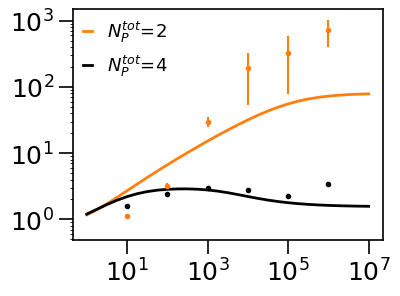

In [12]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        slcRepeat[0], slcRepeat[1], 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Selectivity - NERDSS spatial

see Rockfish under folder twosegments

# Four DNA segments

In [6]:
# results from NERDSS simulations
targetCluster = np.array([1, 2, 3, 4])

## Proteins can form dimers

In [26]:
DNApartition_2 = ([0.        , 0.1932004 , 0.34046152, 0.43666561],
                 [0.        , 0.03428115, 0.02344495, 0.03153427])

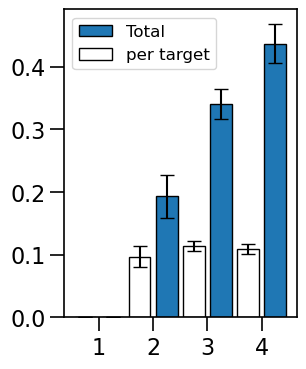

In [31]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_2[0], yerr=DNApartition_2[1],
    capsize=5, edgecolor='black', facecolor='tab:blue', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_2[0]/targetCluster, 
    yerr=DNApartition_2[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

# plt.plot(
#     targetCluster, DNAbound_2/NP_tot_2, color='tab:blue', 
#     marker='^', ls='-', label='dimer'
# )
# plt.plot(
#     targetCluster, DNAbound_2/NP_tot_2/targetCluster, 
#     color='tab:blue', marker='^', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## monomer

In [39]:
DNApartition_1 = ([0.01963284, 0.04229797, 0.07063262, 0.0853417],
                 [0.00603037, 0.00844562, 0.00908131, 0.01204614])

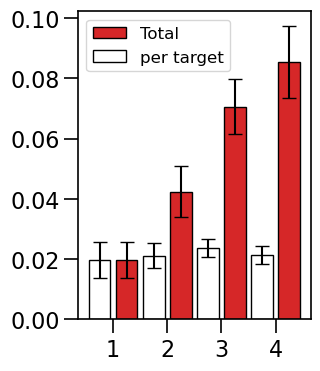

In [40]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_1[0], yerr=DNApartition_1[1],
    capsize=5, edgecolor='black', facecolor='tab:red', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_1[0]/targetCluster, 
    yerr=DNApartition_1[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

# plt.plot(
#     targetCluster, DNAbound_1/NP_tot_1, color='tab:blue', 
#     marker='^', ls='-', label='monomer'
# )
# plt.plot(
#     targetCluster, DNAbound_1/NP_tot_1/targetCluster, 
#     color='tab:red', marker='^', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Linear tetramer

In [37]:
DNApartition_4 = ([0. , 0.08206282, 0.30460399, 0.54261452],
                 [0. , 0.02781052, 0.0716499 , 0.09244663])

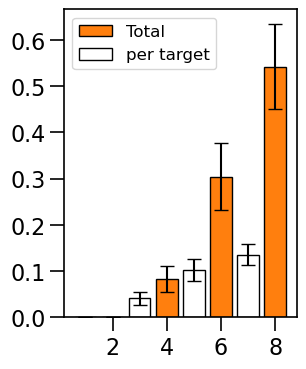

In [38]:
plt.figure(figsize=(3,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_4[0], yerr=DNApartition_4[1],
    capsize=5, edgecolor='black', facecolor='tab:orange', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_4[0]/targetCluster, 
    yerr=DNApartition_4[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)
    
# plt.plot(
#     targetCluster, DNAbound_4/NP_tot_4, color='tab:orange', 
#     marker='o', ls='-', label='tetramer'
# )
# plt.plot(
#     targetCluster, DNAbound_4/NP_tot_4/targetCluster, 
#     color='tab:orange', marker='o', ls='--', markerfacecolor='none',
# )

plt.legend(fontsize=12)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()